<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Overnight_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
!pip3 install pyfolio
import pyfolio as pyf

OVERNIGHT TRADING STRATEGY

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [235]:
!pip install datetime
import datetime

day = 3
month = 8
year = 2019
delta = 4

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "TSLA"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker #+ ".IS"
#       Feasibility
# EREGL 2.26
# ASELS 1.53
# THYAO 0.34
# GARAN 0.78
# KCHOL 0.598
# ISDMR 1.5
# QUAGR 0.90
# CANTE 0.15
# EUPWR 0.59
# YKBNK 0.78
# DOAS  0.81
# INFO  0.34
# TUPRS 0.73

In [236]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# For data manupulations


# VF    LB    PEAK_CUM  CUM_LAST    REVERSED
# 0.25  45    6.11       4.29 OK    True
# 0.35  45    7.42       5.02 OK    True
# 0.40  45    7.64       5.17 OK    True
# 0.45  45    8.99       6.16 OK    True
# 0.45  45    1.22       1.05 OK    False
# 0.45  55    7.97       5.39 OK    True
# 0.45  40    9.35       6.31 OK    True
# 0.45  35    9.65       7.14 OK    True
# 0.45  33    9.78       7.24 OK    True  ***
# 0.45  32    10.02      7.42 OK    True  ****
# 0.45  30    9.16       6.78 OK    True
# 0.45  25    8.19       5.98 OK    True
# -   -       5.17       4.82 OK    True / original Gap up buy side.



# Read data from Yahoo finance

data = yf.download(TickerIS,START, END)

data_close = data['Adj Close']

data_rel = data['Adj Close'] / data['Adj Close'][0]

# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2023-07-27,268.309998,269.130005,255.300003,255.710007,255.710007,103697300,268.309998
2023-07-28,259.859985,267.250000,258.230011,266.440002,266.440002,111446000,259.859985
2023-07-31,267.480011,269.079987,263.779999,267.429993,267.429993,84582200,267.480011
2023-08-01,266.260010,266.470001,260.250000,261.070007,261.070007,83166000,266.260010
2023-08-02,255.570007,259.519989,250.490005,254.110001,254.110001,101368100,255.570007


In [237]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [238]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(R_WINDOW).std()

In [239]:
data['positions'] = np.nan

In [240]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [241]:
# IMPROVED STRATEGY

# Long entry condition
if REVERSED:
  long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
else:
# Short entry condition
  long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']


In [242]:
# Store 1 when long entry condition is true
data.loc[long_entry, 'positions'] = 1

# Store -1 when short entry condition is true
#data.loc[short_entry, 'positions'] = -1

# Store 0 when wait condition is true
data.loc[short_entry, 'positions'] = 0

data['positions'].fillna(method='ffill', inplace=True)

# Drop NaN values
#data = data.dropna()

In [243]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

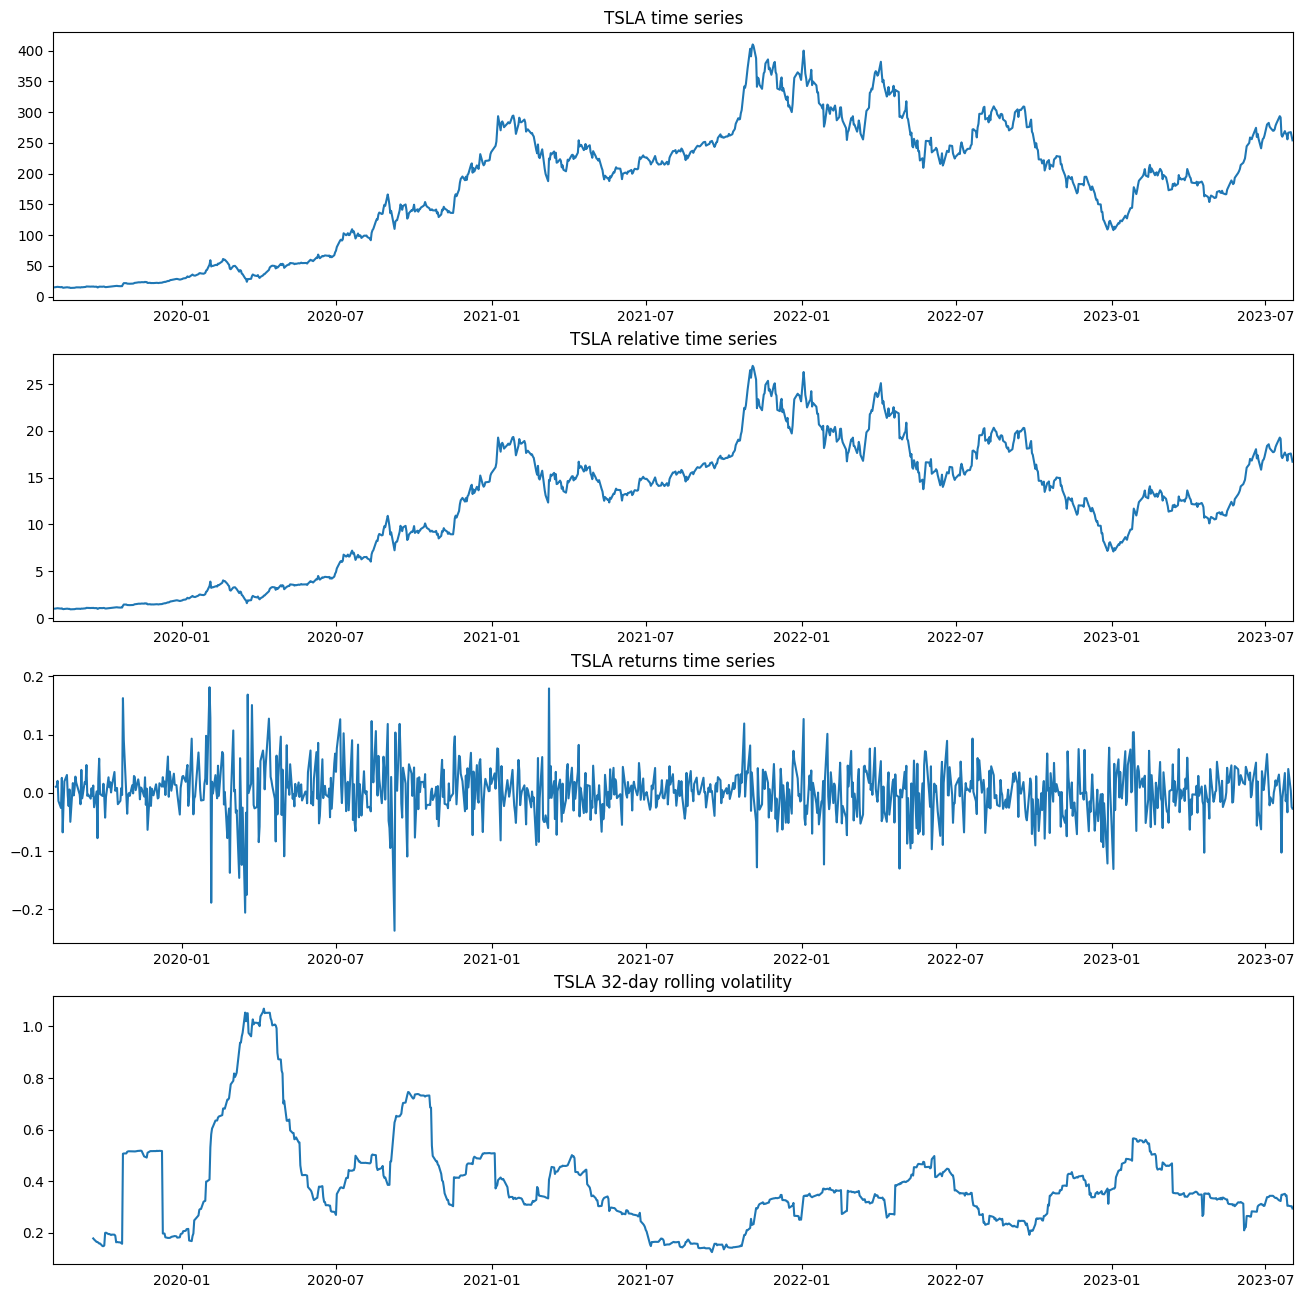

In [244]:
plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series")

plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
plt.plot(data_rel)
plt.title(f"{Ticker} relative time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
plt.plot(data_log_returns)
plt.title(f"{Ticker} returns time series")

plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
data_vlt = data_close.rolling(R_WINDOW).std()*(252**0.5)

plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.plot(data['std']*252**0.5)

fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.show()

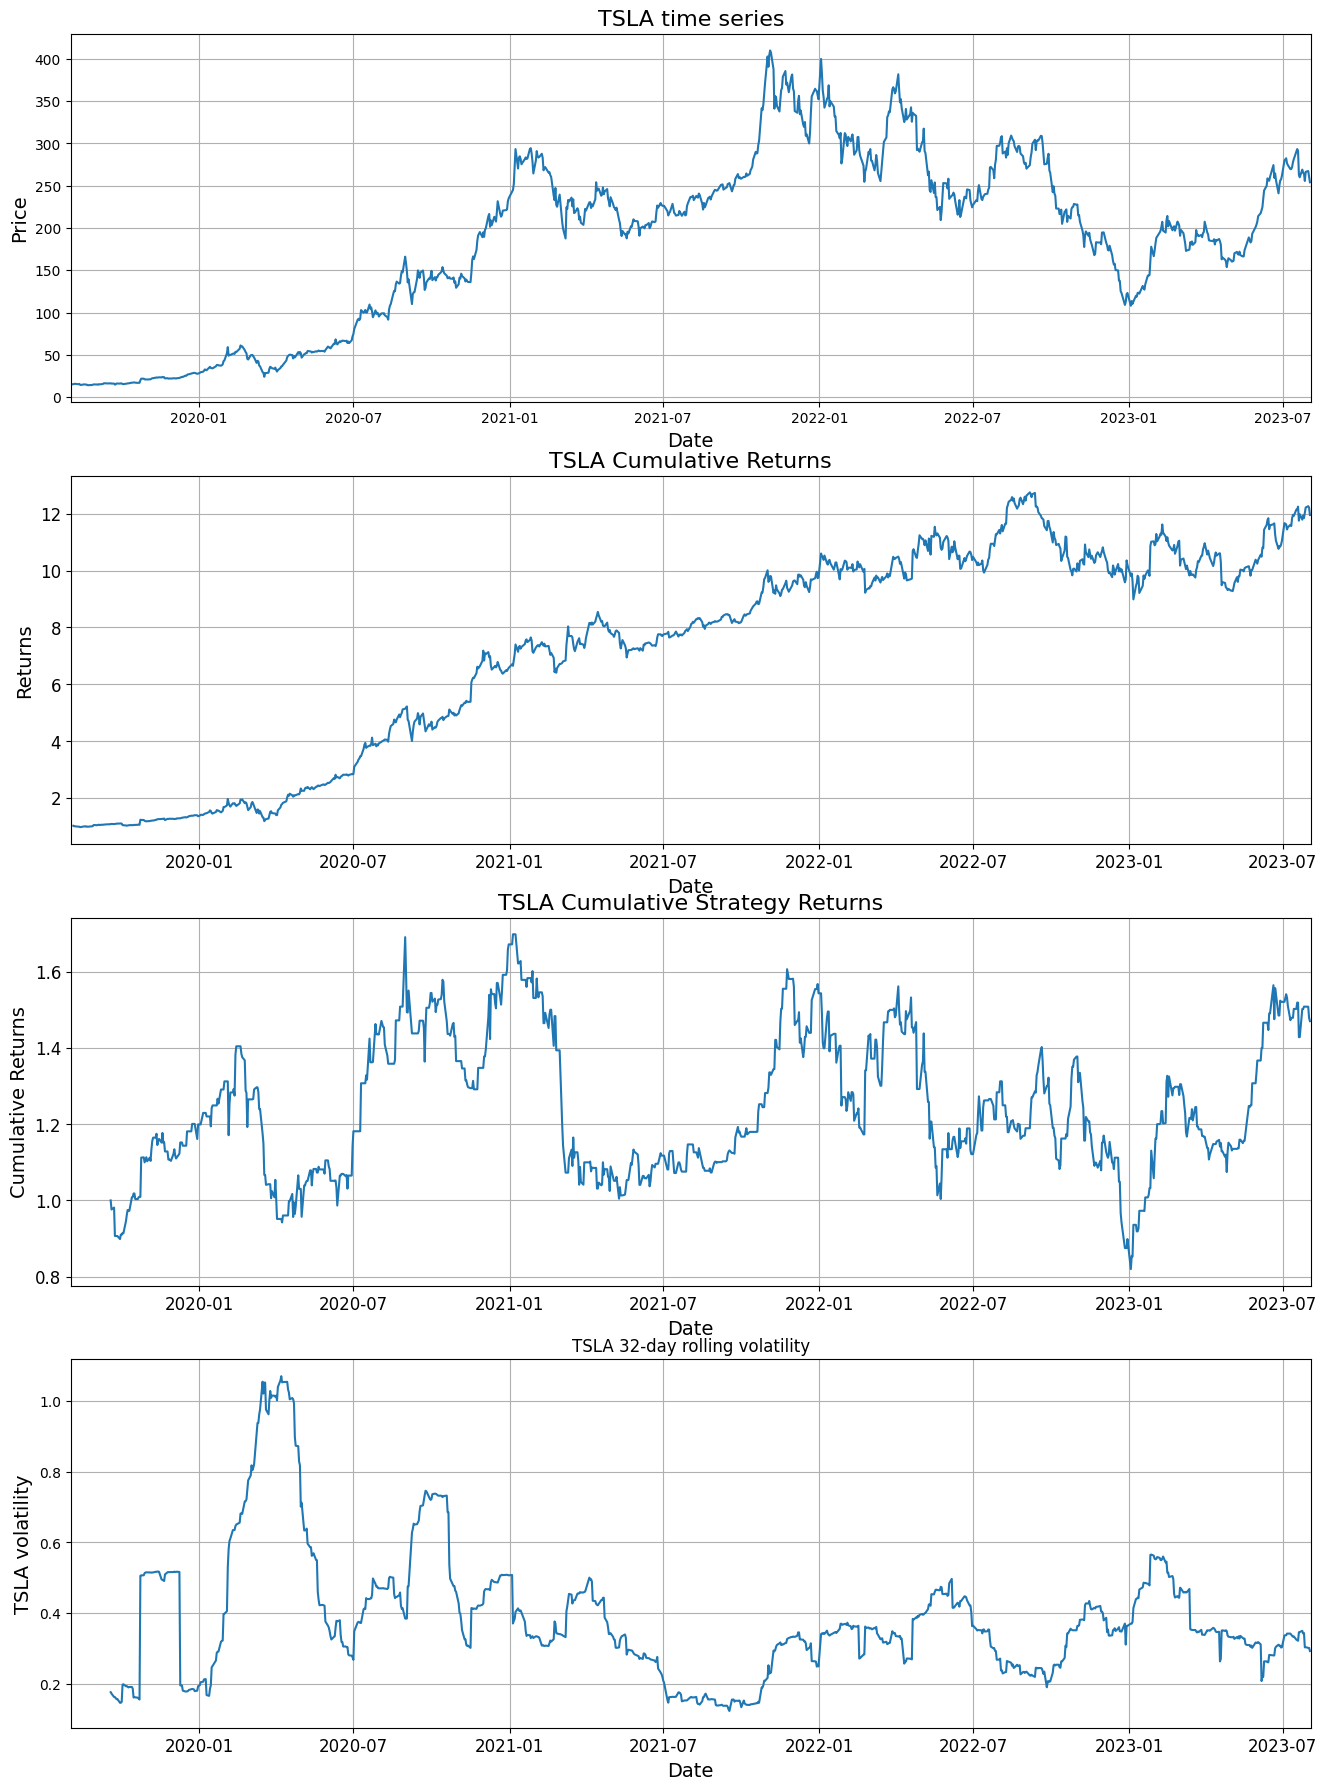

In [245]:
# Plot cumulative returns

import datetime

plt.figure(figsize=(14,11))

plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
data['cumulative_normal_returns'] = (data.returns+1).cumprod()

plt.plot(data.cumulative_normal_returns)
plt.title(f"{Ticker} normal returns")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()


plt.plot(data.cumulative_strategy_returns)
plt.title(f"{Ticker} returns time series")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{Ticker} volatility', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)

plt.plot(data['std']*252**0.5)
fig = plt.gcf()
fig.set_size_inches(16, 22)
plt.show()

In [262]:
data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna()

,Open,High,Low,Close,Adj Close,Volume,Adj Open,returns,std,positions,strategy_returns,cumulative_normal_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,
2019-09-19,16.400000,16.529333,16.322666,16.440001,16.440001,71937000,16.400000,0.010308,0.011201,0.0,0.000000,1.078268,1.000000
2019-09-20,16.432667,16.463333,15.877333,16.041332,16.041332,95295000,16.432667,-0.000446,0.010949,1.0,-0.023814,1.077787,0.976186
2019-09-23,16.000000,16.345333,15.948000,16.082001,16.082001,65103000,16.000000,-0.002577,0.010341,1.0,0.005125,1.075010,0.981189
2019-09-24,16.101334,16.132668,14.840667,14.880667,14.880667,193372500,16.101334,0.001202,0.010336,1.0,-0.075812,1.076302,0.906803
2019-09-25,14.970667,15.265333,14.557333,15.246667,15.246667,141406500,14.970667,0.006048,0.010129,0.0,0.000000,1.082812,0.906803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,268.309998,269.130005,255.300003,255.710007,255.710007,103697300,268.309998,0.014980,0.019159,0.0,-0.000000,12.028021,1.508242
2023-07-28,259.859985,267.250000,258.230011,266.440002,266.440002,111446000,259.859985,0.016229,0.019199,0.0,0.000000,12.223226,1.508242
2023-07-31,267.480011,269.079987,263.779999,267.429993,267.429993,84582200,267.480011,0.003903,0.019058,1.0,-0.000187,12.270938,1.507960


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-08-06
End date,2023-08-02
Total months,47
,Backtest
Annual return,86.3%
Cumulative returns,1096.0%
Annual volatility,42.2%
Sharpe ratio,1.69
Calmar ratio,2.16
Stability,0.78
Max drawdown,-40.0%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


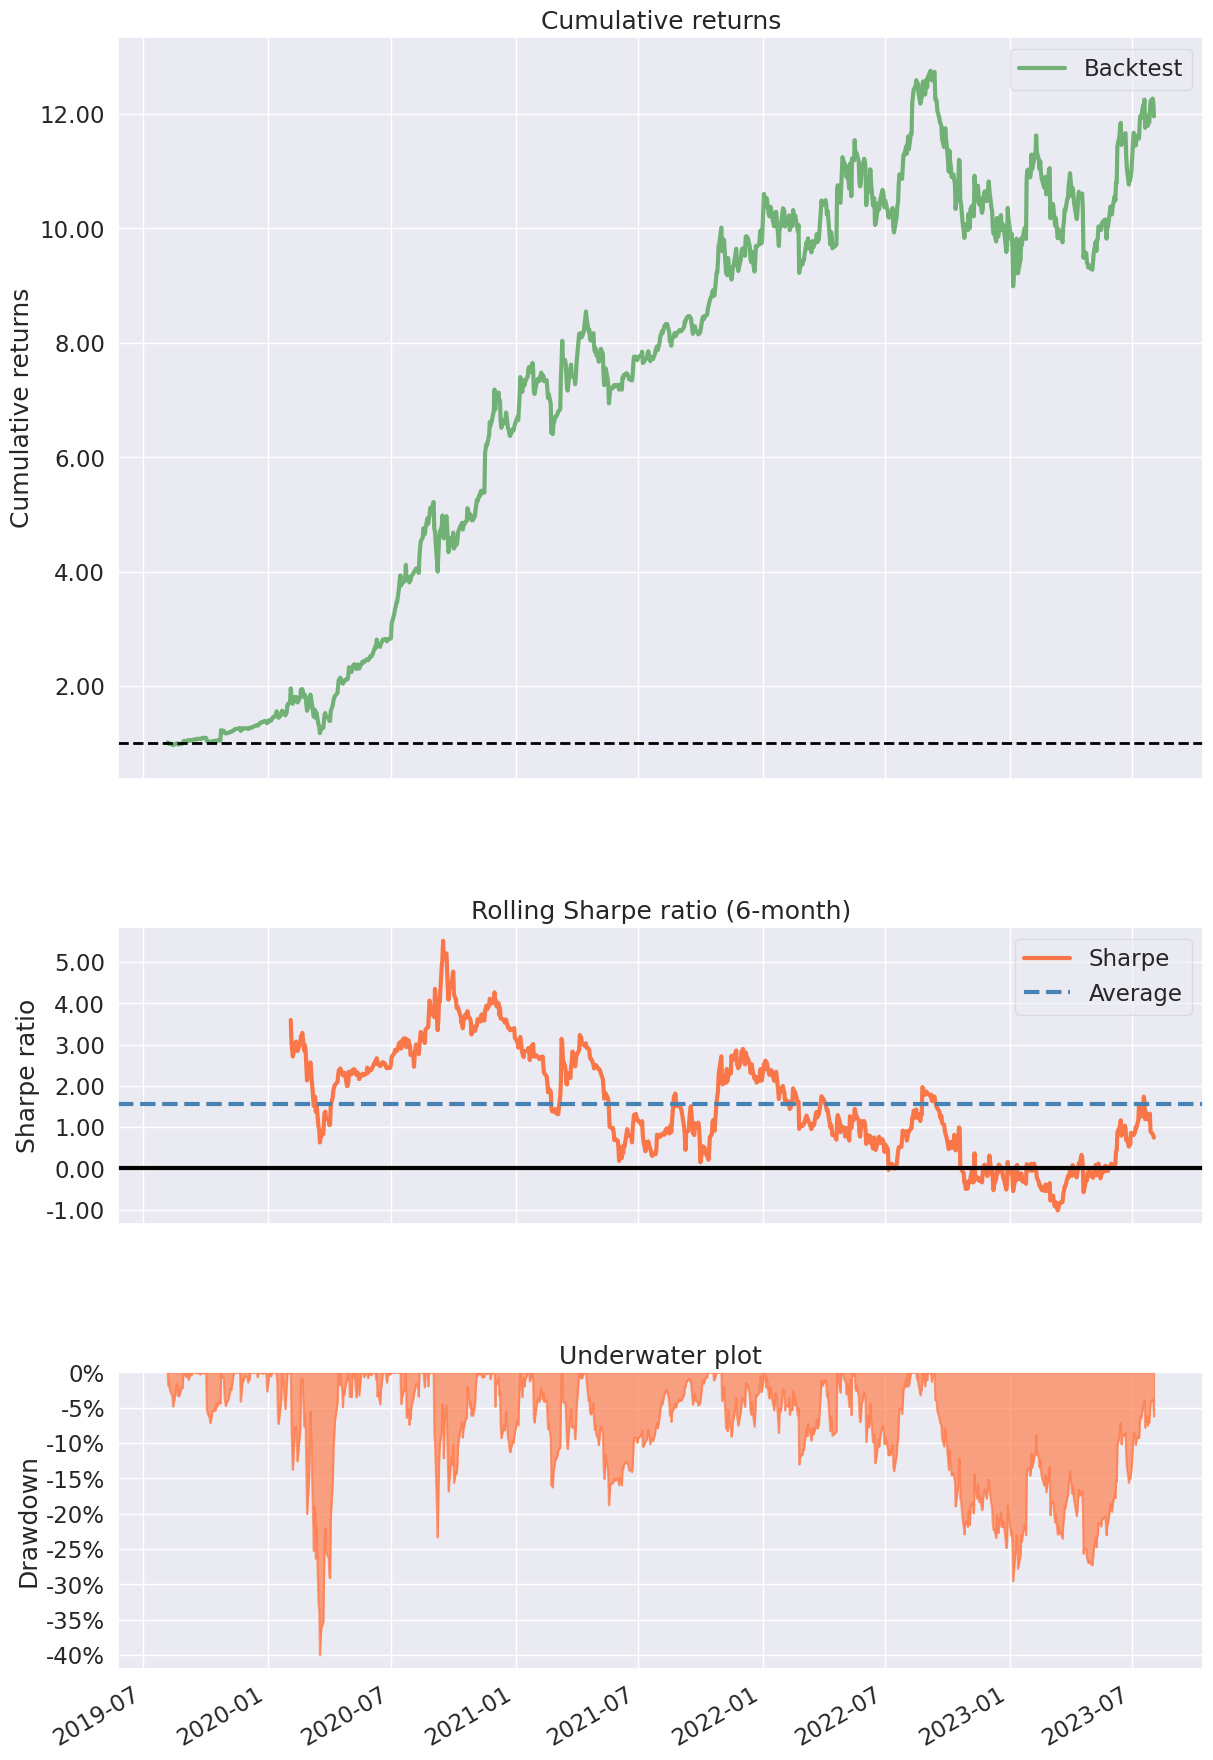

In [247]:
pyf.create_simple_tear_sheet(data.returns.dropna())

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-09-19
End date,2023-08-02
Total months,46
,Backtest
Annual return,10.5%
Cumulative returns,47.0%
Annual volatility,43.5%
Sharpe ratio,0.45
Calmar ratio,0.20
Stability,0.01
Max drawdown,-51.7%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


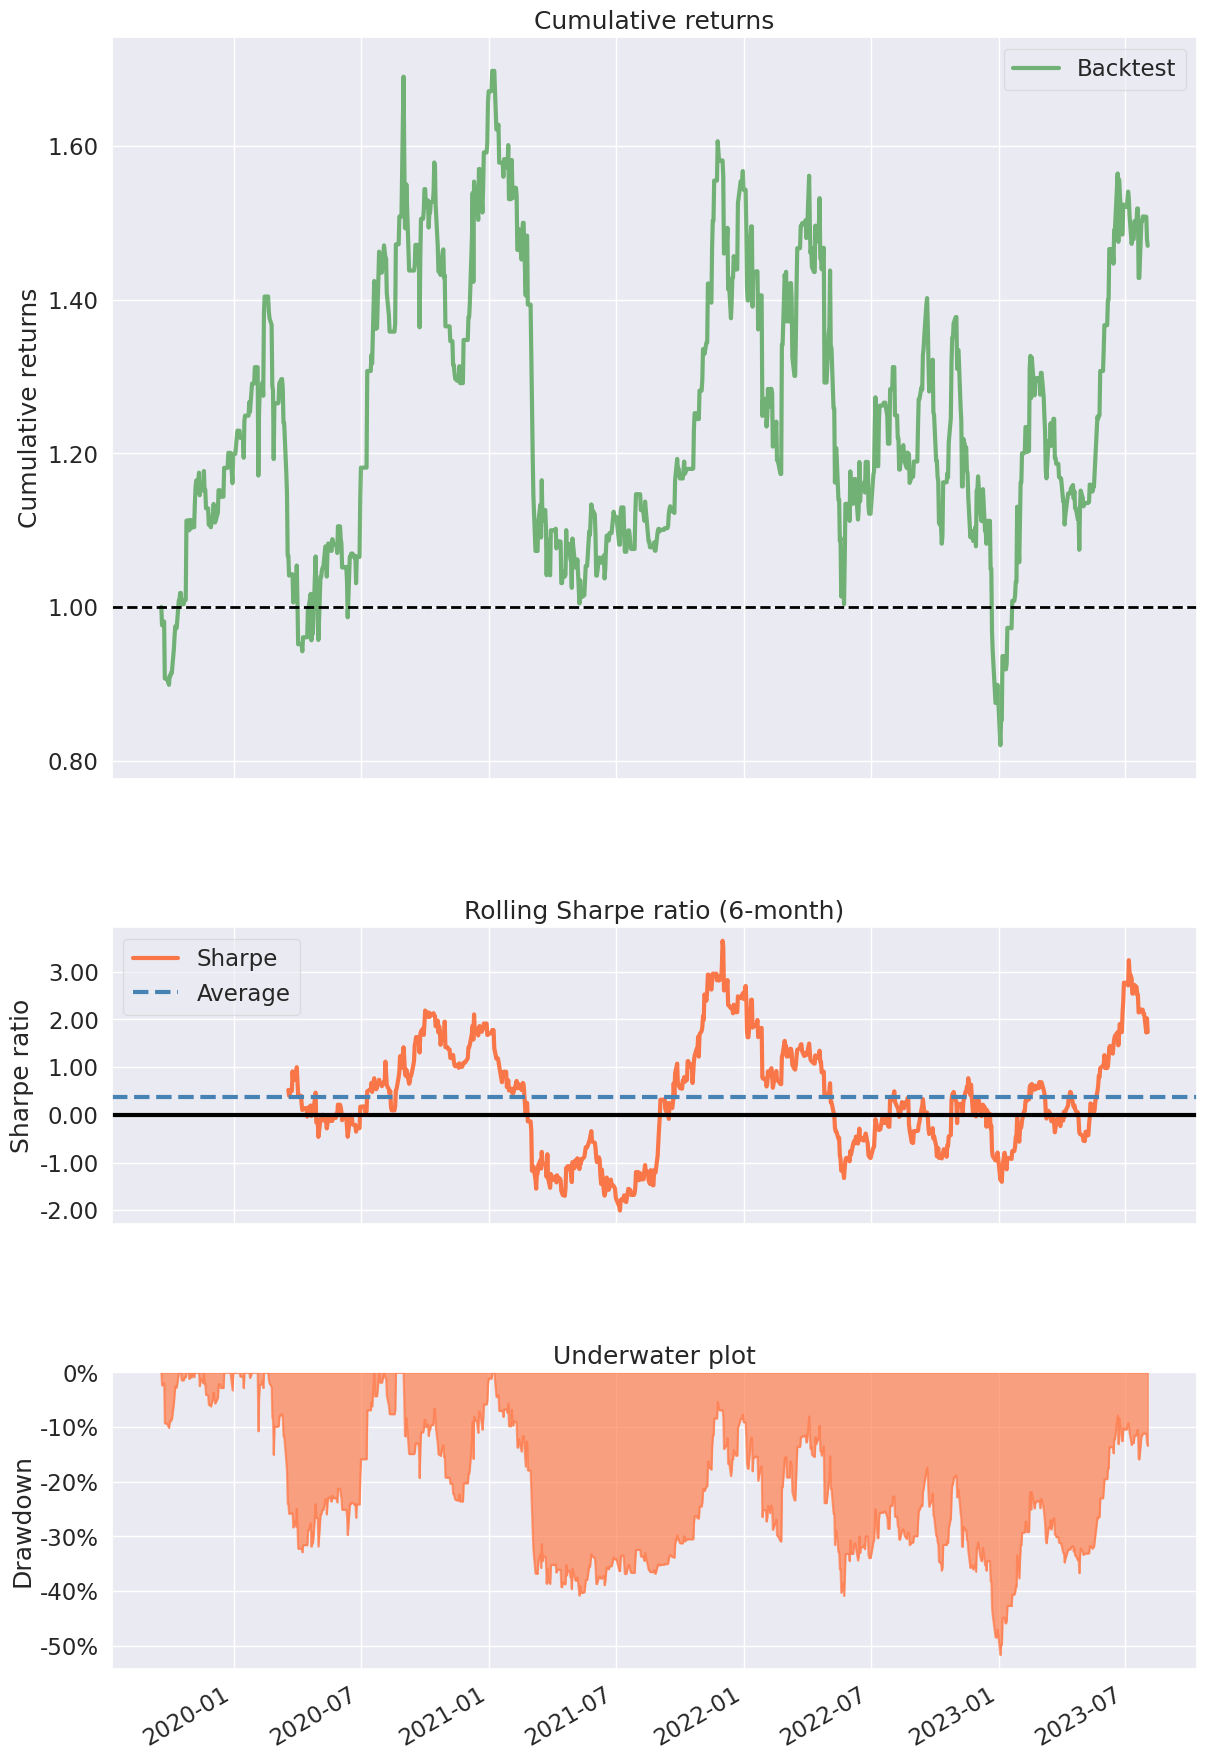

In [248]:
pyf.create_simple_tear_sheet(data.strategy_returns.dropna())

In [249]:
np.max(data.cumulative_normal_returns)

12.756638917892053

In [250]:
(data.cumulative_normal_returns[-1])

11.959870818901926

In [251]:
np.max(data.cumulative_strategy_returns)

1.6979072443410046

In [252]:
(data.cumulative_strategy_returns[-1])

1.4701194109046636

In [253]:
data_rel[-1]

16.69433341495035

In [254]:
data.cumulative_normal_returns[-1]

11.959870818901926

In [255]:
feasible = data.cumulative_normal_returns[-1] / data_rel[-1]

In [256]:
feasible

0.7164030166182886